## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Aprendizaje por transferencia con redes neuronales 


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos una implementación de aprendizaje por transferencia utilizando la red pre-entrenada VGG-16. Implementaremos nuestra propio modelo de aprendizaje por trasferencia utilizando la biblioteca (API) Keras (https://keras.io/). 

Finalmente evaluaremos si un modelo más complejo de *deep learning* nos permite lograr un mejor desempeño para la detección automática de frailejones sobre imagenes aereas del páramo.

Primero importemos algunos de los paquetes que vamos a utilizar, junto con las imagenes de entrenamiento:


In [18]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from ImportImagenesRGB_2 import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import applications

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Aprendizaje por transferencia

En pocas palabras, el aprendizaje por transferencia tiene su historia en la psicología, refiriendose a situaciones donde las personas aplican concimiento, estrategias y aptitudes que han aprendido previamente para enfrentar una nueva situación bajo un contexto **relacionado**. Dentro del aprendizaje computacional, este tipo de aprendizaje se enfoca en guardar un tipo de conocimiento que ya se ha mostrado útil para resolver un problema, y aplicarlo para resolver otro problema distinto pero **relacionado**.

Hay que tener en cuenta que si un modelo de transferencia tiene un efecto negativo sobre el desempeño del modelo, entonces tendremos una transferencia negativa (lo cual no es deseable). De este modo, el reto de los métodos de transferencia es el de producir una transferencia positiva entre tareas apropiadamente relacionadas, evitando transferencias negativas entre tareas poco relacionadas (ver Torrey & Shavlik (2009) Transfer learning). 

El ejemplo que vamos a ver a continuación es un tipo de aprendizaje por transferencia inductivo, característico de las redes neuronales, el cual se ajusta de acuerdo con la coincidencia de un conocimiento previo sobre la fuente de información y la tarea que se propone solucionar. En particular, vamos a llevar a cabo un *aprendizaje por transferencia inductivo-jerárquico*, buscando soluciones a tareas sencillas mediante la combinación de herramientas desarrolladas para tareas más complejas. Entonces, usamos el aprendizaje de una red pre-entrenada, la VGG-16, para aprovechar su conocimiento sobre formas, contornos, bordes, etc. que podemos hacer propias para terminar de entender mejor el problema de clasificación de frailejones, y esperamos mejorar el desempeño de los modelos.


### VGG-16

La red VGG-16 fue propuesta por Simonyan & Zisserman (2015) en Very deep CNN for large-scale image recognition, siguiendo los principios presentados en Ciresan et al. (2011): Flexible, High Performance Convolutional Neural Networks for Image Classification.

La arquitectura de la VGG-16 le permitió ganar la competición ILSVR(Imagenet) 2014 (http://www.image-net.org/challenges/LSVRC/2014/results). Los principios de esta arquitectura consisten en considerar filtros convolucionales pequeños (de $3\times 3$), que recorren las imagenes exhaustivamente, con un *stride* de 1, y capas de *max-poling* de $2\times 2$, reduciendo en gran medida el número de hiper-parámetros a optimizar. La red VGG-16 es bastante profunda, con una configuración de 16 capas (con aprox. 138 millones de parámetros): para las primeras 14 capas combina capas convolucionales y capas de agregación, y al final tiene 2 capa densamente conectadas seguidas de una capa de salida *softmax* para clasificación de múltiples clases (ver: https://neurohive.io/en/popular-networks/vgg16/).


Implementemos nuestro ejemplo de aprendizaje por transferencia utilizando la red VGG-16, la cual ha sido entrenada previamente con imagenes RGB y que podemos descargar directamente de Keras:

In [ ]:
model0   = applications.VGG16(include_top=False, weights='imagenet')
config_transI = model0.get_config()

Pasamos nuestro conjunto de datos por la red, obteniendo los nuevos patrones de acuerdo con el entendimiento de la red convolucional VGG-16 acerca de las nociones más básicas que encuentra en nuestras imagenes del Páramo:

In [ ]:
feat_X = model0.predict(X)

Agregamos unas pocas capas finales para afinar el modelo por transferencia para la tarea específica de detección de imagenes aereas del Páramo:

In [ ]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

model = Sequential()  
model.add(Flatten(input_shape=feat_X.shape[1:]))  
model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))  
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

config_transF = model.get_config()

Y entrenamos esas capas finales:

In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(feat_X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_transF)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('Transfer_Adam_partseed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)


Graficamos el desempeño del modelo:

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [ ]:
# red convolucional
model_4 = load_model('Transfer_Adam_partseed=1.h5')

model_4.summary()

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [ ]:
Y_pred = model_4.predict(feat_X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 144 </td>
       <td> 1 </td>
    </tr>
    <tr>
       <td> 0 </td>
       <td> 105 </td>
    </tr>

</table>

Podemos observar que el desempeño del modelo a mejorado bastante. 

### Ejercicio 1.1

Encuentre el mejor modelo examinando una configuración distinta para las capas de salida, o siguiendo alguna otra estrategia como puede ser cambiando el optimizador o las funciones de activación.

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [ ]:
from keras.preprocessing.image import image

img = image.load_img('IMG_3451.JPG')
img 

### 2.1 Red sencilla

In [ ]:
# red sencilla 5 neuronas
model_1 = load_model('modelo_redsencilla_initseed=1_part_seed=3numn=5.h5')

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_1.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### 2.2 Red multi-capa

In [ ]:
# red profunda de 6 capas
model_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_2.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### 2.3 Red Convolucional

In [ ]:
# red convolucional sencilla
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_3.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### 2.4 Red Convolucional VGG-16 con transferencia

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        feat_subi2 = model0.predict(subi2)
        Y_preds = model_4.predict(feat_subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### Pregunta 2.1

¿Qué puede observar sobre el desempeño de los diferentes modelos? Argumente cuál es el mejor modelo para poner en producción.

### Ejercicio 2.2

Investigue otra red pre-entrenada dsitinta a la VGG-16 e implemente el aprendizaje por transferencia para la deteccion de frailejones. Argumente por qué su justifica el aprendizaje por transferencia con base en el modelo pre-entrenado de su elección (cómo se relacionan la tarea base y la segunda tarea objetivo).

In [8]:
model0   = applications.VGG19(include_top=False, weights='imagenet')
config_transI = model0.get_config()
feat_X = model0.predict(X)

#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

model = Sequential()  
model.add(Flatten(input_shape=feat_X.shape[1:]))  
model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))  
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

config_transF = model.get_config()


# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(feat_X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_transF)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('VGG19Transfer_Adam_partseed='+str(r)+'.tf')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: VGG19Transfer_Adam_partseed=3.tf\assets
Epoca= 99 , accu_v1=0.9729729890823364 , accu_v2=0.9473684430122375
Epoca= 99 , accu_v1=0.9729729890823364 , accu_v2=0.8947368264198303
INFO:tensorflow:Assets written to: VGG19Transfer_Adam_partseed=1.tf\assets
Epoca= 99 , accu_v1=0.9729729890823364 , accu_v2=1.0
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.973  | 0.9474 |   99  |
|  1.0   | 0.973  | 0.8947 |   99  |
|  1.0   | 0.973  |  1.0   |   99  |
+--------+--------+--------+-------+


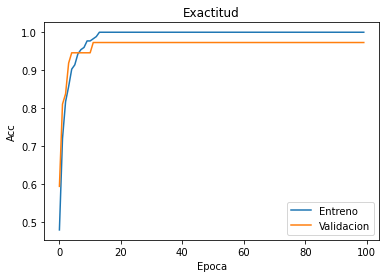

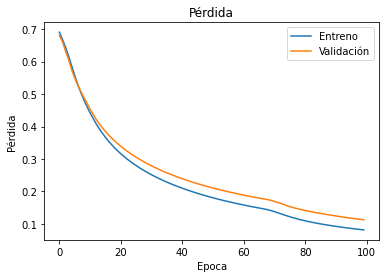

In [9]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [10]:
model0   = applications.ResNet50(include_top=False, weights='imagenet')
config_transI = model0.get_config()
feat_X = model0.predict(X)

#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

model = Sequential()  
model.add(Flatten(input_shape=feat_X.shape[1:]))  
model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))  
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

config_transF = model.get_config()


# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(feat_X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_transF)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('VGG19Transfer_Adam_partseed='+str(r)+'.tf')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: VGG19Transfer_Adam_partseed=3.tf\assets
Epoca= 0 , accu_v1=0.4324324429035187 , accu_v2=0.6052631735801697
Epoca= 0 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697
Epoca= 2 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.6057 | 0.4324 | 0.6053 |   0   |
|  0.6   | 0.4595 | 0.6053 |   0   |
| 0.5771 | 0.5405 | 0.6316 |   2   |
+--------+--------+--------+-------+


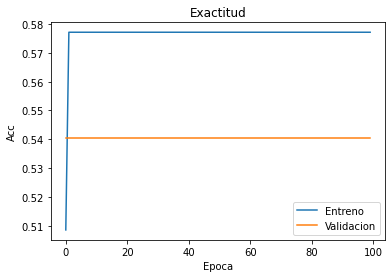

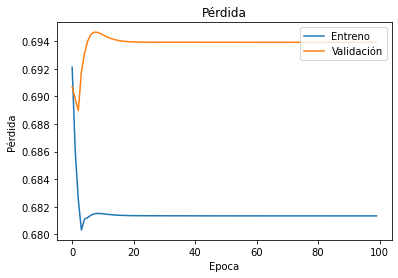

In [11]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

### Ejercicio 2.3
Construya un algoritmo que utilice el mejor modelo de red neuronal para la detección de poblaciones en la imagen completa IMG_3451.JPG, y estime la densidad para cada población detectada.

*Ayuda:* Mediante un procedimiento sencillo, primero detecte las poblaciones de frailejones y luego estime su densidad, calculada como el numero de frailejones por area poblada.